## **Galaxy Classification**

## 1. Data Loading and Visualization
- Load training and test datasets
- Display sample images and class distribution

In [82]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dir = '/Users/eylul/Downloads/galaxies/train'
test_dir = '/Users/eylul/Downloads/galaxies/test'


In [83]:
# transform to tensor
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [84]:
train_set = ImageFolder(train_dir, transform=basic_transform)
test_set = ImageFolder(test_dir, transform=basic_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

class_names = train_set.classes
print("Classes:", class_names)


Classes: ['barred', 'elliptical', 'irregular', 'spiral']


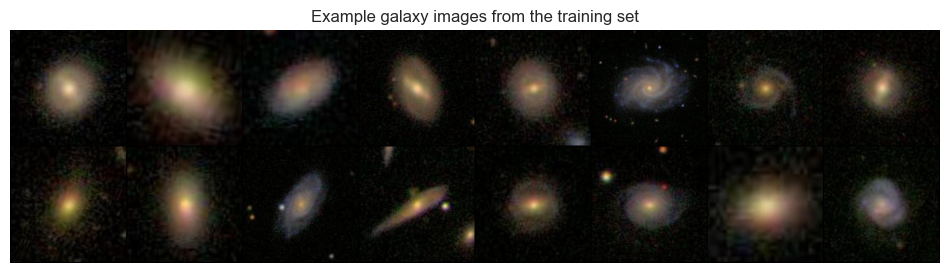

Labels: ['barred', 'elliptical', 'elliptical', 'barred', 'barred', 'spiral', 'spiral', 'barred', 'elliptical', 'elliptical', 'spiral', 'irregular', 'barred', 'spiral', 'elliptical', 'spiral']


In [85]:
# Batch
images, labels = next(iter(train_loader))

plt.figure(figsize=(12, 6))
grid = make_grid(images[:16], nrow=8, normalize=True).permute(1, 2, 0)
plt.imshow(grid)
plt.axis("off")
plt.title("Example galaxy images from the training set")
plt.show()

print("Labels:", [class_names[i] for i in labels[:16]])


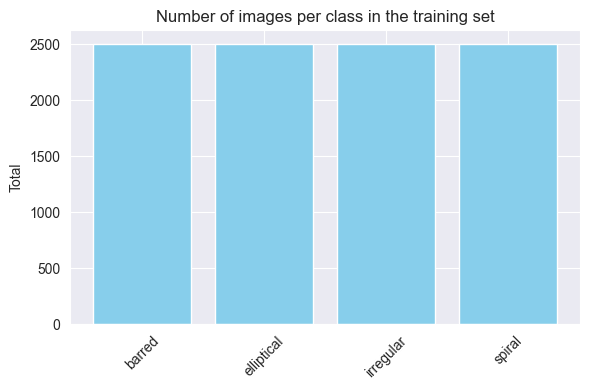

,Class,Total
0,barred,2500
1,elliptical,2500
2,irregular,2500
3,spiral,2500


In [95]:
from collections import Counter
import pandas as pd

counts = Counter([sample[1] for sample in train_set])
counts = {class_names[k]: v for k, v in counts.items()}

plt.figure(figsize=(6, 4))
plt.bar(counts.keys(), counts.values(), color="skyblue")
plt.title("Number of images per class in the training set")
plt.ylabel("Total")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

pd.DataFrame(counts.items(), columns=["Class", "Total"])


## 2. Feature Extraction for Logistic Regression
- Color Histogram
- Edge Direction Histogram
- Co-occurrence Matrix

In [87]:
def color_histogram(img, bins=64):
    n = img.shape[0]
    img = (img * bins).long().clamp(0, bins - 1)
    img = img + torch.arange(0, 3 * n * bins, bins, device=img.device).view(n, 3, 1, 1)
    hist = torch.bincount(img.view(-1), minlength=(3 * n * bins)).view(n, 3 * bins)
    return hist / img[0, 1].numel()


def edge_direction_histogram(img, bins=64):
    n = img.shape[0]
    SOBEL = torch.tensor([
        [[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]],
        [[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]]
    ], dtype=img.dtype, device=img.device)
    gray = img.mean(1, True)
    grad = torch.nn.functional.conv2d(gray, SOBEL)
    magnitude = grad.norm(dim=1)
    angle = torch.atan2(grad[:, 0], grad[:, 1])
    directions = (bins * angle / (2 * torch.pi)).long() % bins
    directions = directions + torch.arange(0, n * bins, bins, device=img.device).view(n, 1, 1)
    hist = torch.bincount(directions.view(-1), weights=magnitude.view(-1), minlength=n * bins).view(n, bins)
    hist = hist / hist.sum(1, True).clamp(1e-6)
    return hist


def _cooccurrence_matrix_dir(values, bins, di, dj):
    b, m, n = values.shape
    codes = values[:, :m - di, :n - dj] + bins * values[:, di:, dj:]
    codes += torch.arange(0, b * (bins ** 2), bins ** 2, device=values.device).view(b, 1, 1)
    entries = torch.bincount(codes.view(-1), minlength=b * (bins ** 2)).view(b, bins, bins)
    return entries


def rgb_cooccurrence_matrix(img, quantization=3, distance=10):
    n = img.shape[0]
    img = (img * quantization).long().clamp(0, quantization - 1)
    img = (img * (torch.arange(3, device=img.device) ** quantization).view(1, 3, 1, 1)).sum(1)
    bins = quantization ** 3
    mat = _cooccurrence_matrix_dir(img, bins, distance, 0)
    mat += _cooccurrence_matrix_dir(img, bins, 0, distance)
    mat = (mat + mat.permute(0, 2, 1)).view(n, -1)
    mat = mat / mat.sum(1, True)
    return mat

Combining low-level features

In [88]:
def get_features(images, color_hist=True, edge_hist=True, rgb_cooc=True):
    features = []

    if color_hist:
        features_color = color_histogram(images, bins=64).to(device)
        features.append(features_color)

    if edge_hist:
        features_edge = edge_direction_histogram(images, bins=64).to(device)
        features.append(features_edge)

    if rgb_cooc:
        features_cooc = rgb_cooccurrence_matrix(images, quantization=3, distance=10).to(device)
        features.append(features_cooc)

    return torch.cat(features, dim=1)

## 3. Logistic Regression Model Training
- Training with low-level features
- Accuracy and confusion matrix evaluation

In [89]:
from torch import nn, optim

for images, _ in train_loader:
    sample_features = get_features(images)
    break

feature_dim = sample_features.shape[1]
num_classes = len(train_set.classes)


model = nn.Linear(feature_dim, num_classes).to(device)

loss_fun = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [92]:
EPOCHS = 15
model.train()

steps = 0
for epoch in range(EPOCHS):
    for images, labels in train_loader:
        features = get_features(images).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(features)
        loss = loss_fun(logits, labels)
        loss.backward()
        optimizer.step()
        steps += 1
        if steps % 100 == 0:
            predictions = torch.argmax(logits, dim=1)
            accuracy = (predictions == labels).float().mean()
            print(f"Epoch: {epoch}, Steps: {steps}, Loss: {loss.item():.4f}, Accuracy: {accuracy * 100:.1f}%")

Epoch: 0, Steps: 100, Loss: 0.7988, Accuracy: 75.0%
Epoch: 0, Steps: 200, Loss: 0.9956, Accuracy: 65.6%
Epoch: 0, Steps: 300, Loss: 1.0250, Accuracy: 59.4%
Epoch: 1, Steps: 400, Loss: 1.1253, Accuracy: 53.1%
Epoch: 1, Steps: 500, Loss: 1.0330, Accuracy: 53.1%
Epoch: 1, Steps: 600, Loss: 0.9109, Accuracy: 62.5%
Epoch: 2, Steps: 700, Loss: 0.8945, Accuracy: 71.9%
Epoch: 2, Steps: 800, Loss: 0.9337, Accuracy: 65.6%
Epoch: 2, Steps: 900, Loss: 1.0423, Accuracy: 56.2%
Epoch: 3, Steps: 1000, Loss: 0.9123, Accuracy: 65.6%
Epoch: 3, Steps: 1100, Loss: 0.7519, Accuracy: 71.9%
Epoch: 3, Steps: 1200, Loss: 0.9271, Accuracy: 68.8%
Epoch: 4, Steps: 1300, Loss: 0.8504, Accuracy: 71.9%
Epoch: 4, Steps: 1400, Loss: 0.9428, Accuracy: 68.8%
Epoch: 4, Steps: 1500, Loss: 0.8703, Accuracy: 71.9%
Epoch: 5, Steps: 1600, Loss: 1.0264, Accuracy: 56.2%
Epoch: 5, Steps: 1700, Loss: 0.9144, Accuracy: 71.9%
Epoch: 5, Steps: 1800, Loss: 1.0005, Accuracy: 62.5%
Epoch: 6, Steps: 1900, Loss: 0.9234, Accuracy: 71.9%
Ep

In [93]:
model.eval()
nclasses = len(class_names)
cm = torch.zeros(nclasses, nclasses, dtype=torch.long)

for images, labels in test_loader:
    features = get_features(images).to(device)
    labels = labels.to(device)
    with torch.no_grad():
        logits = model(features)
    predictions = torch.argmax(logits, dim=1)

    codes = labels * nclasses + predictions
    hist = torch.bincount(codes.cpu(), minlength=nclasses ** 2)
    cm += hist.view(nclasses, nclasses)

accuracy = cm.diag().sum() / cm.sum()
print(f"Test Accuracy: {100 * accuracy:.1f}%")

Test Accuracy: 70.0%


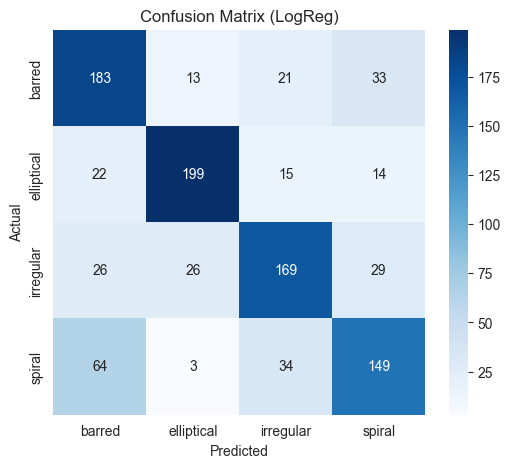

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(cm.numpy(), annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (LogReg)")
plt.show()

## 4. Preprocessing for CNN (ResNet18)
- Define transforms
- Define data loaders

In [103]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import torch.nn as nn
import torch.optim as optim

In [104]:
weights = ResNet18_Weights.DEFAULT

resnet = models.resnet18(weights=weights)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [106]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.RandomRotation(180),
    #transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

transform_test = transforms.Compose([
    #transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_set_cnn = ImageFolder(train_dir, transform=transform_train)
test_set_cnn = ImageFolder(test_dir, transform=transform_test)

train_loader_cnn = torch.utils.data.DataLoader(train_set_cnn, batch_size=32, shuffle=True, num_workers=8)
test_loader_cnn = torch.utils.data.DataLoader(test_set_cnn, batch_size=32, shuffle=False, num_workers=8)

class_names = train_set_cnn.classes


## 5. ResNet18 Transfer Learning Model
- Load pretrained model
- Replace final layer
- Define loss and optimizer

In [107]:
resnet = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
resnet.fc = torch.nn.Linear(resnet.fc.in_features, 4)
resnet = resnet.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)

## 6. CNN Training and Evaluation
- Train ResNet18 with different settings
- Accuracy and confusion matrix evaluation

In [108]:
EPOCHS = 5
resnet.train()

steps = 0
for epoch in range(EPOCHS):
    for images, labels in train_loader_cnn:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        steps += 1
        if steps % 100 == 0:
            predictions = torch.argmax(outputs, dim=1)
            accuracy = (predictions == labels).float().mean()
            print(f"Epoch: {epoch}, Steps: {steps}, Loss: {loss.item():.4f}, Accuracy: {accuracy * 100:.1f}%")

Epoch: 0, Steps: 100, Loss: 0.4576, Accuracy: 84.4%
Epoch: 0, Steps: 200, Loss: 0.3238, Accuracy: 87.5%
Epoch: 0, Steps: 300, Loss: 0.2748, Accuracy: 90.6%
Epoch: 1, Steps: 400, Loss: 0.1803, Accuracy: 96.9%
Epoch: 1, Steps: 500, Loss: 0.3758, Accuracy: 87.5%
Epoch: 1, Steps: 600, Loss: 0.1837, Accuracy: 93.8%
Epoch: 2, Steps: 700, Loss: 0.3176, Accuracy: 90.6%
Epoch: 2, Steps: 800, Loss: 0.1963, Accuracy: 93.8%
Epoch: 2, Steps: 900, Loss: 0.2147, Accuracy: 93.8%
Epoch: 3, Steps: 1000, Loss: 0.0898, Accuracy: 100.0%
Epoch: 3, Steps: 1100, Loss: 0.1333, Accuracy: 93.8%
Epoch: 3, Steps: 1200, Loss: 0.1093, Accuracy: 100.0%
Epoch: 4, Steps: 1300, Loss: 0.4931, Accuracy: 87.5%
Epoch: 4, Steps: 1400, Loss: 0.3287, Accuracy: 90.6%
Epoch: 4, Steps: 1500, Loss: 0.1192, Accuracy: 93.8%


In [109]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

resnet.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader_cnn:
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = sum([p == l for p, l in zip(all_preds, all_labels)]) / len(all_preds)
print(f"Test Accuracy: {100 * acc:.2f}%")

Test Accuracy: 93.70%


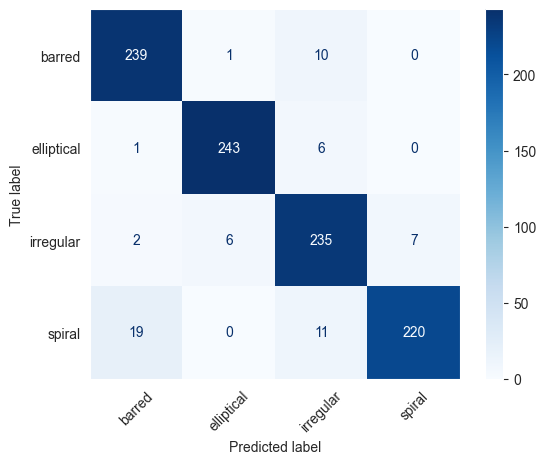

In [110]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.grid(False)
plt.show()